In [1]:
%matplotlib inline

In [2]:
from collections import namedtuple
import os, sys
print( os.getcwd() )
print( os.listdir( os.getcwd() ) )
import time

/home/topolo/PropD/MLgrabbag/kaggle
['stage1.7z.part', 'LSTM_model201702271930.save', 'cleaning_dueSigmaFin.pyc', 'LSTM_model201702280608.save', '.ipynb_checkpoints', 'dueSigmaFinancial_kaggle.py', 'LSTM_model.save', 'LSTM_model201703012346.save', 'glass-classification.zip', 'DatSciBow2017_FullPreprocessTutorial.ipynb', 'LSTM_model201702282350.save', 'GRU_model201703022010.save', 'DueSigmaFin_runs.ipynb', 'dueSigmaFinancial_local.ipynb', 'GRU_model201703012348.save', 'GRU_model201703021741.save', 'kaggle.ipynb', 'glass.csv', 'train.h5.zip', '__init__.py', 'train.h5', 'stage1.torrent', 'dueSigmaFinancial_local_GRUs.ipynb', 'cleaning_dueSigmaFin.py']


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six.moves import cPickle

In [4]:
import theano

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is enabled with initial size: 40.0% of memory, cuDNN 5105)


In [5]:
from theano import function, config, sandbox, shared 
import theano.tensor as T

In [6]:
print( theano.config.device )
print( theano.config.lib.cnmem)  # cf. http://deeplearning.net/software/theano/library/config.html
print( theano.config.print_active_device)# Print active device at when the GPU device is initialized.

gpu0
0.4
True


In [7]:
print(theano.config.allow_gc)
print(theano.config.optimizer_excluding)

False



In [8]:
sys.path.append( '../ML' )

In [9]:
from GRUs_Right import *

In [10]:
timeseries_pd = pd.read_hdf( 'train.h5')

In [28]:
import cleaning_dueSigmaFin
from cleaning_dueSigmaFin import clean_tseries, clean_test, id_only, split_tseries,y_only, calc_R, calc_Pearson_R

In [12]:
train_to_all = 0.85 
T_0 = 906 # timestamp to stop at
num_valid = 100 # how many time steps to validate on # 10
obs_train = timeseries_pd[timeseries_pd["timestamp"]<int(T_0*train_to_all)]  # kaggle call these "observation"


In [13]:
# clean training data
cleaned_obs_train = clean_tseries( obs_train)
obs_valid = timeseries_pd[
    (timeseries_pd['timestamp']>=int(T_0*train_to_all)) & (timeseries_pd['timestamp']<int(T_0*(train_to_all)+num_valid))]
cleaned_obs_valid = clean_tseries( obs_valid)

In [14]:
# this is for a second try, with smaller number of layers
L = Gates(z=2,r=2,h=2,y=3)
n_in = 110 # s1
H = 110
s_2 = 50

s_l = Gates(z=[n_in,H],r=[n_in,H],h=[H,H],y=[H,s_2,1])

activations=Psis(z=(T.nnet.sigmoid,T.nnet.sigmoid),r=(T.nnet.sigmoid,T.nnet.sigmoid),h=(T.tanh,T.tanh),
                 y=(T.nnet.sigmoid,None))

In [15]:
lambda_learn =0.0000002  # regularization for cost function # 0.01 # 0.0000001
alpha_reg = 0.000001 # learning rate # 0.00001 
beta_mom = 0.000000001 # momentum constant, old "Mo" (it's an inside joke) # 0.001 # 0.000000001

In [16]:
# for the L2 norm
GRU_model=GRU_MUT001_right(L,s_l,H,1,activations )
Memblck = MemoryBlock_right(H, GRU_model)
Memblck.build_scan_over_t()
Memblck.build_J_L2norm(lambda_learn)  # inputted value, lambda_val, is the learning rate

Total number of parameters: 11 
Total number of parameters: 11 


GpuFromHost.0

In [17]:
# be aware that this step may take more than a few seconds
Memblck.build_update(alpha=alpha_reg,beta=beta_mom)

Total number of parameters: 11 


In [25]:
MAX_ITERS = 10 # 10
%time results_cost = Memblck.train_model_full( cleaned_obs_train, MAX_ITERS ) # 2 # 50, # theano.config.allow_gc =:  False
#CPU times: user 1h 16min 38s, sys: 23min 7s, total: 1h 39min 46s
#Wall time: 1h 39min 44s
# 150 CPU times: user 4h 31min 58s, sys: 29min 30s, total: 5h 1min 29s
# Wall time: 5h 1min 21s
# MAX_ITERS=50  CPU times: user 1h 31min 57s, sys: 11min 6s, total: 1h 43min 3s
# Wall time: 1h 43min 1s
# cnmem=0.4, MAX_ITERS=10 CPU times: user 18min 11s, sys: 2min 45s, total: 20min 56s  Wall time: 20min 56s


theano.config.allow_gc =:  False
CPU times: user 18min 11s, sys: 2min 45s, total: 20min 56s
Wall time: 20min 56s


In [42]:
MAX_ITERS = 100 # MAX_ITERS=100 CPU times: user 3h 59min 33s, sys: 35min 34s, total: 4h 35min 7s; CPU times: user 4h 2min 1s, sys: 38min 31s, total: 4h 40min 32s
%time results_cost = Memblck.train_model_full( cleaned_obs_train, MAX_ITERS ) # MAX_ITERS=2 CPU times: user 4min 40s, sys: 41.2 s, total: 5min 21s
# MAX_ITERS=100 CPU times: user 4h 2min 1s, sys: 38min 31s, total: 4h 40min 32s

theano.config.allow_gc =:  False
CPU times: user 4h 2min 1s, sys: 38min 31s, total: 4h 40min 32s
Wall time: 4h 40min 26s


In [31]:
#print(len(results_cost));print(len(results_cost[0]));print(type(results_cost[0][0]));
#print(dir(results_cost[0][0])); np.array( results_cost[0][0] ) + 0. 
# cast a CudaNdarray as a numpy array as usual to get data back from the GPU
#2
#1047
#<type 'CudaNdarray'>
#['__add__', '__array__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__doc__', '__format__', '__getattribute__', '__getitem__', '__hash__', '__iadd__', '__idiv__', '__init__', '__itruediv__', '__len__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '_dev_data', '_set_shape_i', '_set_stride', '_strides', 'base', 'copy', 'dtype', 'exp', 'gpudata', 'is_c_contiguous', 'mem_size', 'ndim', 'reduce_sum', 'reshape', 'shape', 'size', 'strides', 'take', 'view', 'zeros']
#7.6817378997802734
results_cost # array([ 2392.01805741,  2026.30881399,  1718.79077414,  1460.21671918,
#        1242.77239746,  1059.89497049,   906.07414965,   776.67492714,
 #        667.8074246 ,   576.19623596])
#    array([ 499.09311096,  434.19197716,  379.55148638,  333.53831519,
 #       294.77457814,  262.10549985,  234.56227435,  211.331933  ,
  #      191.72780603,  175.17298945,  161.18276756,  149.35165075,
   #     139.33629566,  130.84899801,  123.64665813,  117.52760176,
    #    112.32031585,  107.88055044,  104.08750449,  100.83924748,
     #    98.05002079,   95.64768349,   93.57117918,   91.76981368,
      #   90.20068056,   88.82773009,   87.62072169,   86.55424258,
       #  85.60652637,   84.7592262 ,   83.9971908 ,   83.30755471,
        # 82.67956948,   82.104293  ,   81.5739191 ,   81.08202097,
         #80.62313188,   80.19265432,   79.78657391,   79.40169733,
         #79.03528562,   78.68498599,   78.34873173,   78.02491135,
         #77.71211131,   77.40903791,   77.11481158,   76.82847728,
         #76.5492742 ,   76.27653115])

array([ 76.00975371,  75.74841108,  75.49209556,  75.24054598,
        74.9934125 ,  74.75049671,  74.51153713,  74.27631294,
        74.04469443,  73.81647502,  73.59152924,  73.36974094,
        73.1510009 ,  72.93522567,  72.72235127,  72.51226596,
        72.30488643,  72.10011468,  71.89789904,  71.69810825,
        71.50072718,  71.30574825,  71.11314285,  70.92284609,
        70.73476145,  70.54886158,  70.36506623,  70.18336344,
        70.00373211,  69.82611257,  69.65048223,  69.47679553,
        69.3050498 ,  69.13522202,  68.967239  ,  68.8010506 ,
        68.63662915,  68.47392935,  68.31295128,  68.15366334,
        67.99603153,  67.84004894,  67.68571973,  67.53296597,
        67.38176911,  67.23208419,  67.08387476,  66.93718501,
        66.79197773,  66.64821152,  66.50584632,  66.36484665,
        66.22519162,  66.08689091,  65.94993202,  65.81429283,
        65.67994089,  65.5468432 ,  65.41496488,  65.28433098,
        65.15490491,  65.02669865,  64.89968294,  64.77

In [21]:
results_cost

array([ 208.68999271,  196.17384224,  184.51532601,  173.65364589,
        163.535571  ,  154.10933666,  145.3276792 ,  137.14510178,
        129.52184793,  122.41859483,  115.80043555,  109.63317656,
        103.88645048,   98.53125428,   93.5405834 ,   88.88907005,
         84.55365502,   80.51235897,   76.74450211,   73.23163303,
         69.95670609,   66.90267833,   64.05488925,   61.40001843,
         58.92394299,   56.6144753 ,   54.46057633,   52.45162899,
         50.57754368,   48.82979661,   47.19936025,   45.67855332,
         44.25959137,   42.93566738,   41.70026356,   40.54712033,
         39.47109725,   38.46691792,   37.52977408,   36.65496045,
         35.83851088,   35.07592645,   34.3639231 ,   33.69898058,
         33.07800723,   32.49809263,   31.95625958,   31.45031453,
         30.97766785,   30.53601499,   30.12338186,   29.73778768,
         29.37733613,   29.04032971,   28.72522689,   28.43077564,
         28.1553002 ,   27.89753963,   27.6565584 ,   27.43106

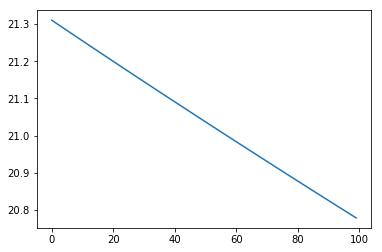

In [85]:
plt.plot(results_cost)

In [19]:
dir( theano.shared( np.array(range(6)).reshape((3,2)).astype(theano.config.floatX)) )
theano.shared( np.array(range(6)).reshape((3,2)).astype(theano.config.floatX)).view()

AttributeError: 'CudaNdarraySharedVariable' object has no attribute 'view'

In [26]:
A=T.matrix(dtype=theano.config.floatX)
B=T.matrix(dtype=theano.config.floatX)
feg = theano.function([A,B],sandbox.cuda.basic_ops.gpu_from_host(T.dot(A,B)) )
C=feg(np.array(range(6)).reshape((3,2)).astype(theano.config.floatX),
      np.array(range(4,10)).reshape((2,3)).astype(theano.config.floatX) )

In [30]:
print(type(C));dir(C);print(type(C.view));print(type(C.view()))

<type 'CudaNdarray'>
<type 'builtin_function_or_method'>
<type 'CudaNdarray'>


In [20]:
cleaned_obs_valid[0][0].shape

(10, 110)

In [54]:
# valid_predictions = Memblck.predict_on_lst( cleaned_obs_valid,verbose=False)
%time valid_predictions = Memblck.predict_on_lst_givens( cleaned_obs_valid,verbose=False)

CPU times: user 4min 51s, sys: 7.86 s, total: 4min 58s
Wall time: 4min 58s


In [24]:
X_cleaned_obs_valid,y_cleaned_obs_valid=split_tseries(cleaned_obs_valid)

In [55]:
valid_predictions_np = [np.array(arr) for arr in valid_predictions]

In [86]:
#R_valid = calc_R(valid_predictions,y_cleaned_obs_valid)
R_valid = calc_R(valid_predictions_np,y_cleaned_obs_valid)
print(R_valid) # -37.9900914576, -35.089626; # -19.7438594245 # -19.3266766405 -19.01511991 -18.8868142933

-18.1848033605


In [87]:
PearsonR_valid = calc_Pearson_R(valid_predictions_np,y_cleaned_obs_valid)

In [88]:
PearsonR_valid

136.25999

In [35]:
print(calc_R_each(valid_predictions_np,y_cleaned_obs_valid) )

150.027


In [89]:
time.strftime( "%Y%m%d%H%M%S",time.gmtime())

'20170305070903'

In [90]:
f = open('GRU_model'+time.strftime('%Y%m%d%H%M',time.gmtime())+'.save' ,'wb')
for param in Memblck.__get_state__():
    cPickle.dump( param, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

Total number of parameters: 11 


### Load a saved model, load its parameters

In [18]:
print( os.listdir( os.getcwd() ) )


['stage1.7z.part', 'LSTM_model201702271930.save', 'cleaning_dueSigmaFin.pyc', 'LSTM_model201702280608.save', '.ipynb_checkpoints', 'dueSigmaFinancial_kaggle.py', 'LSTM_model.save', 'LSTM_model201703012346.save', 'glass-classification.zip', 'DatSciBow2017_FullPreprocessTutorial.ipynb', 'LSTM_model201702282350.save', 'GRU_model201703022010.save', 'DueSigmaFin_runs.ipynb', 'dueSigmaFinancial_local.ipynb', 'GRU_model201703012348.save', 'GRU_model201703021741.save', 'kaggle.ipynb', 'glass.csv', 'train.h5.zip', '__init__.py', 'train.h5', 'stage1.torrent', 'dueSigmaFinancial_local_GRUs.ipynb', 'cleaning_dueSigmaFin.py']


In [20]:
filename_in = "GRU_model201703021741.save" # change this MANUALLY 
f = open(filename_in,'rb')
number_of_params = len( Memblck.__get_state__() )
loaded_param = []
for _ in range(number_of_params):
    loaded_param.append(cPickle.load(f))
f.close()

Total number of parameters: 11 


EOFError: 

In [23]:
Memblck.__set_state__(*loaded_param)

In [35]:
# Memblck.__get_state__()
# valid_predictions_np,y_cleaned_obs_valid 
print(type(valid_predictions_np));print(type(y_cleaned_obs_valid));print(len(valid_predictions_np));
print(len(y_cleaned_obs_valid));print(type(valid_predictions_np[0]));print(type(y_cleaned_obs_valid[0]));
print(valid_predictions_np[0].shape);print(y_cleaned_obs_valid[0].shape)
print(valid_predictions_np[1].shape);print(y_cleaned_obs_valid[1].shape)

<type 'list'>
<type 'list'>
951
951
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(10, 1)
(10, 1)
(10, 1)
(10, 1)


In [40]:
Rts_test  =calc_R_each(valid_predictions_np,y_cleaned_obs_valid)

IndexError: index 1 is out of bounds for axis 0 with size 1

## Extraneous

In [49]:
m=len(valid_predictions_np)
T=y_cleaned_obs_valid[0].shape[0]
#[np.power(valid_predictions_np[idx][T-1]-y_cleaned_obs_valid[idx][T-1],2) for idx in range(m)]
mu = np.mean( [yvals.mean() for yvals in y_cleaned_obs_valid])

In [34]:
def calc_R_each( yhat,y):
    """
    @type yhat : Python list (of length m, number of examples) of numpy arrays, each of size dims. T,1, where T is the number of time steps predicted for
    @param yhat : predicted y values

    @type y
    """
    m = len(y)  # number of training examples at each time t
    assert m == len(yhat)

    yhat_Tavg = [yhat_val.mean() for yhat_val in yhat]
    y_Tavg    = [y_val.mean() for y_val in y]

    yhat_Tavg = np.array( yhat_Tavg)
    y_Tavg    = np.array( y_Tavg)

    mu = np.mean( y_Tavg )

    num = np.sum(  np.power( yhat_Tavg - y_Tavg,2) )
    dem = np.sum( np.power( y_Tavg - mu ,2 ) )
    R = num/dem
    R = np.sqrt( R)
    
    return R

In [28]:
R_test = calc_R_each( valid_predictions_np, y_cleaned_obs_valid)

In [30]:
np.sqrt( R_test )

149.686

In [53]:
R[0]

array([[ 1.67123961],
       [ 3.16267943],
       [ 0.01629504],
       [ 1.03388846],
       [ 1.34194529],
       [ 1.05554676],
       [ 1.11785388],
       [ 1.03495133],
       [ 1.0439266 ],
       [ 1.21566224]], dtype=float32)

In [55]:
y[0].mean()

0.046060514

In [56]:
y_cleaned_obs_valid[0].mean()

-0.0030814814

In [52]:
#T_0*train_to_all
def make_valid_set(timeseries_pd, T_f,T_valid):
    obs_valid = []
    for Deltat in range(T_valid):
        t = int( T_f + Deltat + 1 )
        single_t = timeseries_pd[ timeseries_pd['timestamp']== t ]
        obs_valid.append( single_t )
    return obs_valid
    


In [61]:
obs_valid_singles = make_valid_set(timeseries_pd,T_0*train_to_all,100 )

In [73]:
len( split_tseries( clean_tseries(obs_valid_singles[0]) )[1] )

943

### Subsequent training

In [51]:
MAX_ITERS = 50  
%time results_cost = Memblck.train_model_full( cleaned_obs_train, MAX_ITERS )

theano.config.allow_gc =:  False
CPU times: user 2h 7min 8s, sys: 25min 2s, total: 2h 32min 11s
Wall time: 2h 32min 7s


In [57]:
MAX_ITERS = 100  
%time results_cost = Memblck.train_model_full( cleaned_obs_train, MAX_ITERS )

theano.config.allow_gc =:  False
CPU times: user 4h 19min, sys: 59min 44s, total: 5h 18min 44s
Wall time: 5h 18min 36s


In [77]:
MAX_ITERS = 100  
%time results_cost = Memblck.train_model_full( cleaned_obs_train, MAX_ITERS )

theano.config.allow_gc =:  False
CPU times: user 4h 11min 27s, sys: 44min 52s, total: 4h 56min 20s
Wall time: 4h 56min 12s


In [78]:
%time valid_predictions = Memblck.predict_on_lst_givens( cleaned_obs_valid,verbose=False)
# valid_predictions_np = [np.array(arr) for arr in valid_predictions]

CPU times: user 4min 48s, sys: 7.14 s, total: 4min 55s
Wall time: 4min 55s


In [83]:
MAX_ITERS = 100  
%time results_cost = Memblck.train_model_full( cleaned_obs_train, MAX_ITERS )

theano.config.allow_gc =:  False
CPU times: user 4h 7min 32s, sys: 31min 53s, total: 4h 39min 25s
Wall time: 4h 39min 18s


In [84]:
%time valid_predictions = Memblck.predict_on_lst_givens( cleaned_obs_valid,verbose=False)
valid_predictions_np = [np.array(arr) for arr in valid_predictions]

CPU times: user 4min 50s, sys: 8.09 s, total: 4min 58s
Wall time: 4min 58s
